The goal of this notebook is to align all datasets and clean them.
---
There are going to be four datasets:
1. Yahoo finance stock prices & volumes
1. Yahoo finance stock info (sector, industry)
1. Ycharts operating margin ttm
1. Ycharts derived asset turnover


In [117]:
import numpy as np
import pandas as pd
import seaborn as sns
import json


First, load new tickers, derived from ycharts asset turnover dataset:

In [118]:
with open("./data/new_aligned_tickers_2128.json") as jsf:
    new_tickers = json.load(jsf)

# Loading datasets

## Load yf prices an volumes

In [119]:
stocks_yf = (
    pd.read_csv(
        filepath_or_buffer="./data/yf/stocks3m_yf.csv.xz",
        compression="xz",
        header=[0, 1],
        index_col=[
            0,
        ],
        parse_dates=True,
    )
    .sort_index(axis=0)
    .sort_index(axis=1)
)

prices, volume = (
    stocks_yf.loc[:, "adj_close"], # type: ignore
    stocks_yf.loc[:, "volume"], # type: ignore
)

volume = volume.loc[:, new_tickers]
prices = prices.loc[:, new_tickers]

# Since yf volume represents number of shares, convert them to USD
volume = volume * prices

In [120]:
# calculate log-returns
returns = (1 + prices.pct_change()).apply(np.log)
returns.head(4)

,A,AACAF,AACAY,AAL,AAON,AAP,AAPL,AAT,AATC,AAV.TO,...,SCVL,SCX,SCXLB,SDVKY,SEB,SECVY,SEE,SEGXF,SEIC,SEKEY
Date,,,,,,,,,,,,,,,,,,,,,
2010-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-04-01,0.586536,0.638088,NaN,0.034250,0.355194,0.157275,0.288566,NaN,-0.174176,0.208848,...,0.385273,0.098881,0.025782,0.378927,0.475129,0.325556,0.210389,0.043658,0.109220,0.301198
2012-04-01,-0.262032,0.124053,0.236969,0.402843,-0.135850,0.157420,0.553773,0.118403,-0.795562,-0.934785,...,0.066868,0.154782,0.248840,-0.287481,-0.125421,-1.209188,-0.405714,-0.460342,-0.109512,-0.552735
2013-04-01,0.096460,0.624154,0.672239,0.208483,0.579970,0.177140,-0.372497,0.272265,0.365460,0.324496,...,0.166484,-0.088756,-0.330763,-0.033939,0.243728,0.060166,0.470759,0.268264,0.386543,0.316270


In [121]:
prices.info()
print()
volume.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14 entries, 2010-04-01 to 2023-04-01
Columns: 2128 entries, A to SEKEY
dtypes: float64(2128)
memory usage: 232.9 KB

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14 entries, 2010-04-01 to 2023-04-01
Columns: 2128 entries, A to SEKEY
dtypes: float64(2128)
memory usage: 232.9 KB


## Load yf stock info

In [122]:
company_info = pd.read_csv("./data/yf/company_info.csv")

In [123]:
company_info.sector.unique()

array(['Healthcare', 'Technology', 'Industrials', 'Consumer Cyclical',
       'Real Estate', 'Energy', 'Consumer Defensive', 'Basic Materials',
       'Utilities', 'Financial Services', 'Communication Services'],
      dtype=object)

## Load Ycharts Operating Margins

In [124]:
ychopmdf = (
    pd.read_csv(
        "data/ycharts/operating_margin_ttm.csv",
        parse_dates=True,
        index_col=0,
    )
    .sort_index(axis=1)
    .sort_index(axis=0)
    .drop("2009-04-01")
    .loc[:, new_tickers]
)

In [125]:
ychopmdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14 entries, 2010-04-01 to 2023-04-01
Columns: 2128 entries, A to SEKEY
dtypes: float64(2128)
memory usage: 232.9 KB


## Ycharts Asset Turnover

In [126]:
asset_turnover = (
    pd.read_csv("./data/ycharts/asset_turnover.csv", parse_dates=True, index_col=0)
    .drop("2009-04-01")
    .sort_index(axis=1)
    .sort_index(axis=0)
    .loc[:, new_tickers]
)

In [127]:
asset_turnover.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14 entries, 2010-04-01 to 2023-04-01
Columns: 2128 entries, A to SEKEY
dtypes: float64(2128)
memory usage: 232.9 KB


# Find common tickers

In [128]:
different_tickers = [
    prices.columns,
    volume.columns,
    company_info.ticker.to_list(),
    ychopmdf.columns,
    asset_turnover.columns,
]

In [129]:
aligned_tickers = sorted(list(set(different_tickers[0]).intersection(*different_tickers)))
len(aligned_tickers)

2128

In [130]:
# import json


# with open(f"./data/new_aligned_tickers_2128.json", "w") as jsf:
#     json.dump(aligned_tickers, jsf)

<Axes: xlabel='Number of misses across two datasets', ylabel='Frequency'>

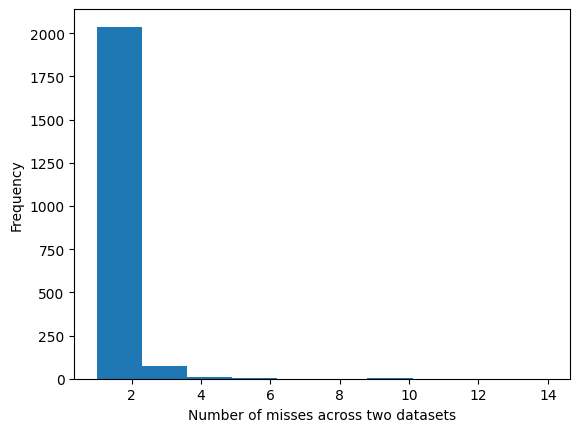

In [131]:
mask_cna = ~(returns.isna() | volume.isna() | ychopmdf.isna() | asset_turnover.isna())
(~mask_cna).sum().plot(kind="hist", xlabel="Number of misses across two datasets")

<Axes: ylabel='Date'>

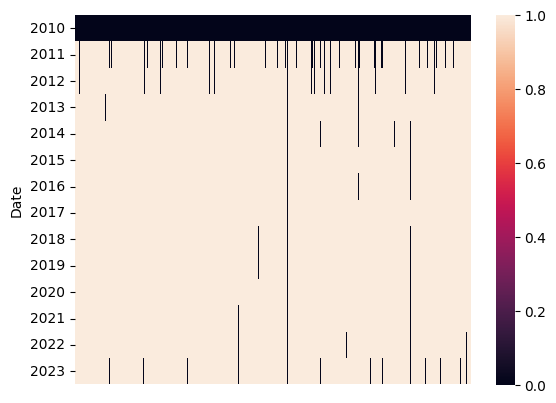

In [132]:
sns.heatmap(mask_cna, xticklabels=False, yticklabels=prices.index.year)  # type: ignore

# Aligning
Year 2010 wiil be dropped due to insufficient data.

In [133]:
df_dict= {
    "prices": prices,
    "returns": returns,
    "volume": volume,
    "ychopmdf": ychopmdf,
    "asset_turnover": asset_turnover,
}
for elem in df_dict:
    df_dict[elem] = df_dict[elem].where(mask_cna, other=np.nan).iloc[1:]

In [137]:
for _name, _df in df_dict.items():
    _df.to_csv(f"./data/aligned_data/{_name}.csv")